# Les codes avec des commantaires et décorations

Les codes contiennent seulement deux classes, `GrapheFortementConnexe` et `TestGraph`. Dans la classe `GrapheFortementConnexe`, il y a des fonctions membres privées et variables membres privées qui ne sont pas expliquées dans son documentation. Mais ces fonctions et variables sont utilisés dans les fonctions membres publiques. Donc pour bien compredre les codes, je vous demande de lire les décorations des fonctions membres privées.

In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib.cm
import matplotlib.patches as mpatches
import numpy as np

In [2]:
class GrapheFortementConnexe:
    """
    La classe pour nous aider à résoudre le problème.
    
    
    Paramètres
    ---------------------------
    cfc_dict : Le dictionnaire pour stocker les composants fortement connexes.
    
    cfc_pont_list : Les arêtes entre les composants fortement connectés dans le 
        graphe original.
        
    aretes_cfc : Les arêtes qui doivent être ajoutées pour connecter le graphe 
        contracté en un seul graphe connexe.
        
    aretes_restes : Les arêtes qui doivent être ajoutées pour connecter le graphe
        connexe contracté en un graphe fortement connexe.
        
    aretes : Les arêtes qui doivent être ajoutées pour connecter le graphe original
        en un graphe fortement connexe.
        
    resultat : le nombre minimum d'arêtes à ajouter pour connecter le graphe
        original en un graphe fortement connexe.
        
    G : Le graphe origine, de type nx.DiGraph().
    
    G_inv : Le graphe inverse de G, de type nx.DiGraph()
    """
    cfc_dict = None
    cfc_pont_list = None
    aretes_cfc = None
    aretes_restes = None
    aretes = None
    resultat = None

    def __init__(self, G):
        """
        Prendre en entrée un graphe orienté et initialiser les paramètres G et G_inv.
        """
        self.G = G
        # Etiqueter les sommets dans les arbres de parcours en profondeur
        self._groupe = {node: 0 for node in G.nodes}
        # Initialiser le paramètre G_inv
        self._inverse()
        # L'étiquette pour les fonctions _dfs_total et kosaraju, comme une variable globale
        self._label_nombre = 0

    def _inverse(self):  # O(m)
        """
        La fonction pour inverser le graphe G. C-à-d inverser les sens des arêtes.
        """
        G_inv = nx.DiGraph()
        G_inv.add_nodes_from(self.G.nodes)
        G_inv.add_edges_from([(j, i) for (i, j) in self.G.edges])
        self.G_inv = G_inv

    def _dfs(self, G, x0, label):  # O(m+n)
        """
        En utilisant l'algorithme parcours en profondeur pour trouver le post-order
        des sommets rancontrés dans G à partir de x0. Etiqueter-les comme label. 
        Renvoyer les sommets dans une liste dfn_res.
        """
        P = [x0]  # Le pile
        dfn_res = []  # Le résultat
        self._groupe[x0] = label  # Changer le label de x0
        while P:
            t = P[-1]
            count = 0  # Pour compter les sommets successifs
            # Si t a des sommets successifs
            if G.succ[t]:
                # Parcourir tous les sommets successifs de t.
                for s in G.succ[t]:
                    count += 1
                    # Si s n'est pas visité, alors enpiler s et changer le label de s.
                    if self._groupe[s] == 0:
                        P.append(s)
                        self._groupe[s] = label
                        break
                    # Si tous les sommets successifs sont visités, alors dépiler t.
                    if count == len(G.succ[t]):
                        courant = P.pop()
                        dfn_res.append(courant)  # Ajouter dans la liste de résultat
                        self._groupe[courant] = label
            # Si t n'a pas de sommet successif, alors enpiler t et changer le label de t.
            else:
                courant = P.pop()
                dfn_res.append(courant)
                self._groupe[courant] = label
        return dfn_res

    def _dfs_total(self):
        """
        Choisir un sommet de G, et puis parcourir en profondeur à partir de ce sommet 
        en utilisant la fonction _dfs.
        
        Trouver tous les arbres de parcours en profondeur de graph G. Renvoyer les arbres
        dans une liste
        """
        arbre_list = []
        while not all(self._groupe.values()):
            self._label_nombre += 1
            non_visite = [s for s in self.G.nodes if self._groupe[s] == 0]
            racine = non_visite[0]
            dfn_res = self._dfs(self.G, racine, self._label_nombre)
            arbre_list.append(dfn_res)
        return arbre_list

    def _dfs_reversed(self, G, x0):
        """
        L'algorithme de parcours en profondeur pour le graphe inverse. Cette fonction
        est utilisée dans la fonction kosaraju.
        """
        P = [x0]
        label = self._groupe[x0]
        dfn_res = []
        est_visite = {s: False for s in G.nodes}
        while P:
            t = P.pop()
            if not est_visite[t]:
                est_visite[t] = True
                dfn_res.append(t)
                for s in G.succ[t]:
                    if self._groupe[s] == label:
                        P.append(s)
        return dfn_res

    def kosaraju(self):  # O(m+n)
        """
        Trouvez toutes les composantes fortement connexes, et les arêtes reliant
        chaque composante fortement connexe dans le graphe origine.
        """
        cfc_dict = {}
        arbre_list = self._dfs_total()    # O(p*(n+m)/p) = O(n+m)
        cfc_pont_list = []  # les arêtes entre les composante fortement connexes.
        for i in range(len(arbre_list)):  # p*O(n/p+(n+m)/p+n/p+m/p)
            arbre_dict = {sommet: 1 for sommet in arbre_list[i]}  # O(n/p)
            cfc_nombre = 0
            # Trouver les cfcs dans ce arbre.
            while arbre_dict:
                cfc_nombre += 1
                self._label_nombre += 1
                # dfs_rev est un cfc de label "self._label_nombre"
                dfs_rev = self._dfs_reversed(self.G_inv, list(arbre_dict.keys())[-1])  # O((n+m)/p)
                cfc_dict[self._label_nombre] = dfs_rev
                # Etiqueter les sommets de dfs_rev par self._label_nombre
                for s in dfs_rev:  # O(n/p)
                    del arbre_dict[s]  # O(1)
                    self._groupe[s] = self._label_nombre
            # Trouver les arêtes entre les cfcs dont le départ est le sommet de cet arbre.
            # C'est une parcours au tous les arêtes d'un arbre sans répétition.
            for j in arbre_list[i]:  # O(m/p)
                for k in self.G.succ[j]:
                    # Si le label de j n'est pas égale à celui de k, alors c'est une arête que l'on veut.
                    if self._groupe[j] != self._groupe[k]:
                        cfc_pont_list.append((self._groupe[j], self._groupe[k]))
        self.cfc_dict = cfc_dict
        self.cfc_pont_list = cfc_pont_list
        return


    def _sommet_type(self, x0):  # O(1)
        """
        Justifier le type de sommet(feuille ou racine). Renvoyer une liste.
        """
        G = nx.DiGraph()
        G.add_nodes_from(self.cfc_dict)
        G.add_edges_from(self.cfc_pont_list)
        res = []
        if not G.succ[x0]:
            res.append('f')
        if not G.pred[x0]:
            res.append('r')
        return res

    def _dfs_non_oriente(self):  # O(m+n)
        """
        L'algorithme de parcours en profondeur pour un graphe non orienté, pour trouver
        tous les graphes orientés acycliques dans le graphe contracté, et leurs racines
        et feuilles. Renvoyer une list dans laquelle chaque élément contient seulement
        ses racines (une liste) et ses feuilles (une liste).
        """
        # Créer le graphe contracté non orienté
        G = nx.Graph()
        G.add_nodes_from(self.cfc_dict)
        G.add_edges_from(self.cfc_pont_list)
        groupe = []  # Le résultat à renvoyer
        est_visite = {s: False for s in G.nodes}
        sommets_non_visite = list(G.nodes)
        while not all(est_visite.values()):
            P = [sommets_non_visite[0]]
            racines = []
            feuille = []
            while P:
                t = P.pop()
                if not est_visite[t]:
                    # Vérifier le type de ce sommet et l'ajouter à la liste correspondante. 
                    # Si il n'est ni racine ni feuille, ne faire rien.
                    sommet_type = self._sommet_type(t)  # O(1)
                    if 'r' in sommet_type:
                        racines.append(t)
                    if 'f' in sommet_type:
                        feuille.append(t)
                    est_visite[t] = True
                    sommets_non_visite.remove(t)
                    for s in G.adj[t]:
                        P.append(s)
            groupe.append([racines, feuille])
        return groupe

    def connexion(self):  # O(n+m)
        """
        Transformer le graphe contracté et le graphe origine en les graphes orientés
        fortement connexes.
        """
        groupe = self._dfs_non_oriente()   # O(n+m)
        resultat = 0  # Le nombre minimal d'arêtes à ajouter
        racines_restes = []
        feuilles_restes = []
        # Les arêtes qui doivent être ajoutées pour connecter le graphe contracté en un seul graphe connexe.
        aretes_cfc = []

        # Connecter d'abord plusieurs graphes orientés acycliques en un graphe orienté
        # acyclique. Remarque: ce graphe est le graphe contracté
        resultat += len(groupe) - 1  # Le nombre d'arêtes ajoutées dans ce processus
        for i in range(resultat):  # Complexité O(q)
            # i-ième feuille connecte à i+1-ième racine
            aretes_cfc.append((groupe[i][1][-1], groupe[i + 1][0][-1]))
            groupe[i][1].pop()  # feuille liste
            groupe[i + 1][0].pop()  # racine liste

        # Les racines et feuilles restes dans le seule graphe orienté acyclique. (Les
        # racines et feuilles ne utilisent pas dans le dernier processus.)
        for i in range(resultat + 1):  # Complexité O(n)
            racines_restes += groupe[i][0]
            feuilles_restes += groupe[i][1]
        l_r = len(racines_restes)
        l_f = len(feuilles_restes)
        resultat += max(l_r, l_f)  # Le résultat final se calcule comme çà

        # Les arêtes qui doivent être ajoutées pour connecter le graphe connexe
        # contracté en un graphe fortement connexe.
        
        # Tout d'abord, nous relions une feuille de la dernière composante et une feuille
        # de la première composante.
        aretes_restes = [(feuilles_restes.pop(), racines_restes.pop(0))]  # O(q)
        l_r -= 1
        l_f -= 1
        # Une des juges est O(q)
        if l_r > l_f:
            aretes_restes += [(feuilles_restes[i], racines_restes[i]) for i in range(l_f)]
            aretes_restes += [(aretes_restes[0][1], racines_restes[i]) for i in range(l_f, l_r)]
        if l_r < l_f:
            aretes_restes += [(feuilles_restes[i], racines_restes[i]) for i in range(l_r)]
            aretes_restes += [(feuilles_restes[i], aretes_restes[0][1]) for i in range(l_r, l_f)]
        if l_r == l_f:
            aretes_restes += [(feuilles_restes[i], racines_restes[i]) for i in range(l_f)]
        # Les arêtes qui doivent être ajoutées pour connecter le graphe original
        # en un graphe fortement connexe.
        aretes = [(self.cfc_dict[i][0], self.cfc_dict[j][0]) for (i, j) in aretes_cfc] 
        aretes += [(self.cfc_dict[i][0], self.cfc_dict[j][0]) for (i, j) in aretes_restes]
        # la somme des duex lignes précédents est O(q)
        self.aretes = aretes
        self.aretes_cfc = aretes_cfc
        self.aretes_restes = aretes_restes
        self.resultat = resultat
        return

    def dessiner_graphe_inverse(self):
        """
        Dessiner le graphe G_inv.
        """
        plt.figure(figsize=(9, 9))
        nx.draw_shell(self.G_inv, with_labels=True, node_size=1000, width=3)
        plt.title("Graphe origine inverse", font='Arial', fontsize=25, y=-0.1)
        plt.show()

    def dessiner_le_processus(self):
        """
        Illustrer le processus de résoudre le problème.
        """
        position1 = nx.shell_layout(self.G)
        # Créer le graphe contracté
        G = nx.DiGraph()
        G.add_nodes_from(self.cfc_dict)
        G.add_edges_from(self.cfc_pont_list)
        position2 = nx.shell_layout(G)
        plt.figure(figsize=(27, 17))
        # Dessiner le graphe origine
        plt.subplot(231)
        nx.draw(self.G, position1, with_labels=True, node_size=1000, width=3)
        plt.title("Graphe origine", font='Arial', fontsize=25, y=-0.1)
        # Dessiner les composents fortement connexes
        plt.subplot(232)
        nx.draw(self.G, position1, with_labels=True, node_size=1000, width=3)
        cfc_nombre = len(self.cfc_dict)
        cmap = matplotlib.cm.get_cmap('rainbow')
        colariage = {key: cmap(i) for i, key in zip(np.linspace(0, 1, cfc_nombre + 1)[:-1], self.cfc_dict.keys())}
        for key, value in self.cfc_dict.items():
            nx.draw_networkx_nodes(self.G, position1, nodelist=value, node_size=1000,
                                   node_color=self.rgba2hex(colariage[key]))
        patches = [mpatches.Patch(color=self.rgba2hex(colariage[key]),
                                  label="{:s}".format(str(key))) for key in self.cfc_dict.keys()]
        ax = plt.gca()
        ax.legend(handles=patches, bbox_to_anchor=(1.35, 0.1), ncol=4)
        plt.title("Composants fortement connexes", font='Arial', fontsize=25, y=-0.1)
        # Dessiner le graphe contracté
        # Les arêtes de ce graphe sont à l'origine, ne sont pas ceux qui sont à ajouter
        plt.subplot(233)
        nx.draw(G, position2, with_labels=True, node_size=1000, width=3)
        plt.title("Graphe contracté", font='Arial', fontsize=25, y=-0.1)
        # Dessiner le graphe orienté acyclique
        # Les nouveau arêtes ajoutés maintenant sont pour completer le graphe comme un
        # graphe orienté acyclique
        G.add_edges_from(self.aretes_cfc)
        plt.subplot(234)
        nx.draw(G, position2, with_labels=True, node_size=1000, width=3)
        nx.draw_networkx_edges(G, pos=position2, edgelist=self.aretes_cfc, width=3,
                               edge_color='b')
        plt.title("Graphe orienté acyclique", font='Arial', fontsize=25, y=-0.1)
        # Dessiner le graphe fortement connexe
        # Les nouveau arêtes ajoutés maintenant sont pour completer le graphe comme un
        # graphe fortement connexe
        G.add_edges_from(self.aretes_restes)
        plt.subplot(235)
        nx.draw(G, position2, with_labels=True, node_size=1000, width=3)
        nx.draw_networkx_edges(G, pos=position2, edgelist=self.aretes_cfc, width=3,
                               edge_color='b')
        nx.draw_networkx_edges(G, pos=position2, edgelist=self.aretes_restes, width=3,
                               edge_color='r')
        plt.title("Graphe fortement connexe", font='Arial', fontsize=25, y=-0.1)
        # Ajouter les arêtes pour vue que le graphe soit un graphe fortement connexe
        self.G.add_edges_from(self.aretes)
        plt.subplot(236)
        nx.draw(self.G, position1, with_labels=True, node_size=1000, width=3)
        for key, value in self.cfc_dict.items():
            nx.draw_networkx_nodes(self.G, position1, nodelist=value, node_size=1000,
                                   node_color=self.rgba2hex(colariage[key]))
        nx.draw_networkx_edges(self.G, position1, edgelist=self.aretes, width=3,
                               edge_color='r')
        plt.title("Graphe fortement connexes", font='Arial', fontsize=25, y=-0.1)
        plt.show()

    @staticmethod
    def rgba2hex(rgba):
        """
        Utilisé dans la fonction dessiner_le_processus pour éliminer les warnings.
        """
        a = rgba[3]
        rgb = [str(hex(round(float(rgba[i] * 255 * a + 255 * (1 - a))))[2:]) for i in range(3)]
        for i in range(3):
            if len(rgb[i]) == 1:
                rgb[i] = '0' + rgb[i]
        return '#' + rgb[0] + rgb[1] + rgb[2]

In [3]:
class TestGraph:
    """
    La classe pour tester noter algorithme. Dans cette classe, il y a 3 graphes orientés
    intégrés, une fonction pour ajouter graph orienté et une fonction pour tester l'algo-
    -rithme. De plus, vous pouver accéder les graphes stockés comme un list.
    """
    __Graph_list = []

    def __init__(self):
        self.__Graph_list.clear()
        G1 = nx.DiGraph()
        G1.add_nodes_from([1, 2, 3, 4, 5, 6])
        G1.add_edges_from([(1, 2), (2, 5), (1, 3), (3, 5),
                           (5, 1), (5, 6), (4, 6), (2, 4)])
        self.__Graph_list.append(G1)
        G2 = nx.DiGraph()
        G2.add_nodes_from(list(range(1, 13)))
        G2.add_edges_from([(9, 2), (2, 5), (5, 3), (3, 5), (5, 8),
                           (1, 6), (6, 1), (1, 8), (8, 1), (8, 6),
                           (6, 8), (3, 7), (5, 7), (7, 4), (4, 7),
                           (7, 10), (10, 7), (11, 12)])
        self.__Graph_list.append(G2)
        G3 = nx.DiGraph()
        G3.add_nodes_from(list(range(1, 8)))
        G3.add_edges_from([(1, 2), (2, 3), (1, 5), (4, 5), (5, 7)])
        self.__Graph_list.append(G3)
        G4 = nx.DiGraph()
        G4.add_nodes_from(range(1, 17))
        G4.add_edges_from([(11, 2), (2, 14), (14, 11), (2, 4), (4, 8),
                           (8, 6), (6, 8), (4, 16), (5, 9), (9, 10),
                           (10, 9), (9, 1), (1, 12), (11, 3), (12, 13),
                           (13, 3), (3, 12), (15, 9), (15, 7)])
        self.__Graph_list.append(G4)
        
    def __getitem__(self, item):
        return self.__Graph_list[item]
    
    def __repr__(self):
        return self.__Graph_list

    def append(self, G):
        """
        Ajouter un graphe orienté.
        """
        if isinstance(G, nx.DiGraph):
            self.__Graph_list.append(G)
        else:
            raise TypeError("Ce n'est pas un graph orienté.")

    @staticmethod
    def demo(G):
        """
        Le processus pour résoudre le problème.
        """
        graphe = GrapheFortementConnexe(G)
        graphe.kosaraju()
        graphe.connexion()
        graphe.dessiner_le_processus()
        print("Les composants fortement connexes sont :")
        for key, value in graphe.cfc_dict.items():
            print("    {} : {}".format(key, value))
        print("Le nombre minimal d'arête à ajouter est : {}".format(graphe.resultat))
        print("Un choix pour les arêtes à ajouter est : {}".format(graphe.aretes))

# Les documentations

In [4]:
help(GrapheFortementConnexe)

Help on class GrapheFortementConnexe in module __main__:

class GrapheFortementConnexe(builtins.object)
 |  GrapheFortementConnexe(G)
 |  
 |  La classe pour nous aider à résoudre le problème.
 |  
 |  
 |  Paramètres
 |  ---------------------------
 |  cfc_dict : Le dictionnaire pour stocker les composants fortement connexes.
 |  
 |  cfc_pont_list : Les arêtes entre les composants fortement connectés dans le 
 |      graphe original.
 |      
 |  aretes_cfc : Les arêtes qui doivent être ajoutées pour connecter le graphe 
 |      contracté en un seul graphe connexe.
 |      
 |  aretes_restes : Les arêtes qui doivent être ajoutées pour connecter le graphe
 |      connexe contracté en un graphe fortement connexe.
 |      
 |  aretes : Les arêtes qui doivent être ajoutées pour connecter le graphe original
 |      en un graphe fortement connexe.
 |      
 |  resultat : le nombre minimum d'arêtes à ajouter pour connecter le graphe
 |      original en un graphe fortement connexe.
 |      


In [5]:
help(TestGraph)

Help on class TestGraph in module __main__:

class TestGraph(builtins.object)
 |  La classe pour tester noter algorithme. Dans cette classe, il y a 3 graphes orientés
 |  intégrés, une fonction pour ajouter graph orienté et une fonction pour tester l'algo-
 |  -rithme. De plus, vous pouver accéder les graphes stockés comme un list.
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, item)
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  append(self, G)
 |      Ajouter un graphe orienté.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  demo(G)
 |      Le processus pour résoudre le problème.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      l

# Une démonstration des codes

------------------------------------------------------------------------------------------

Graphe 1 :


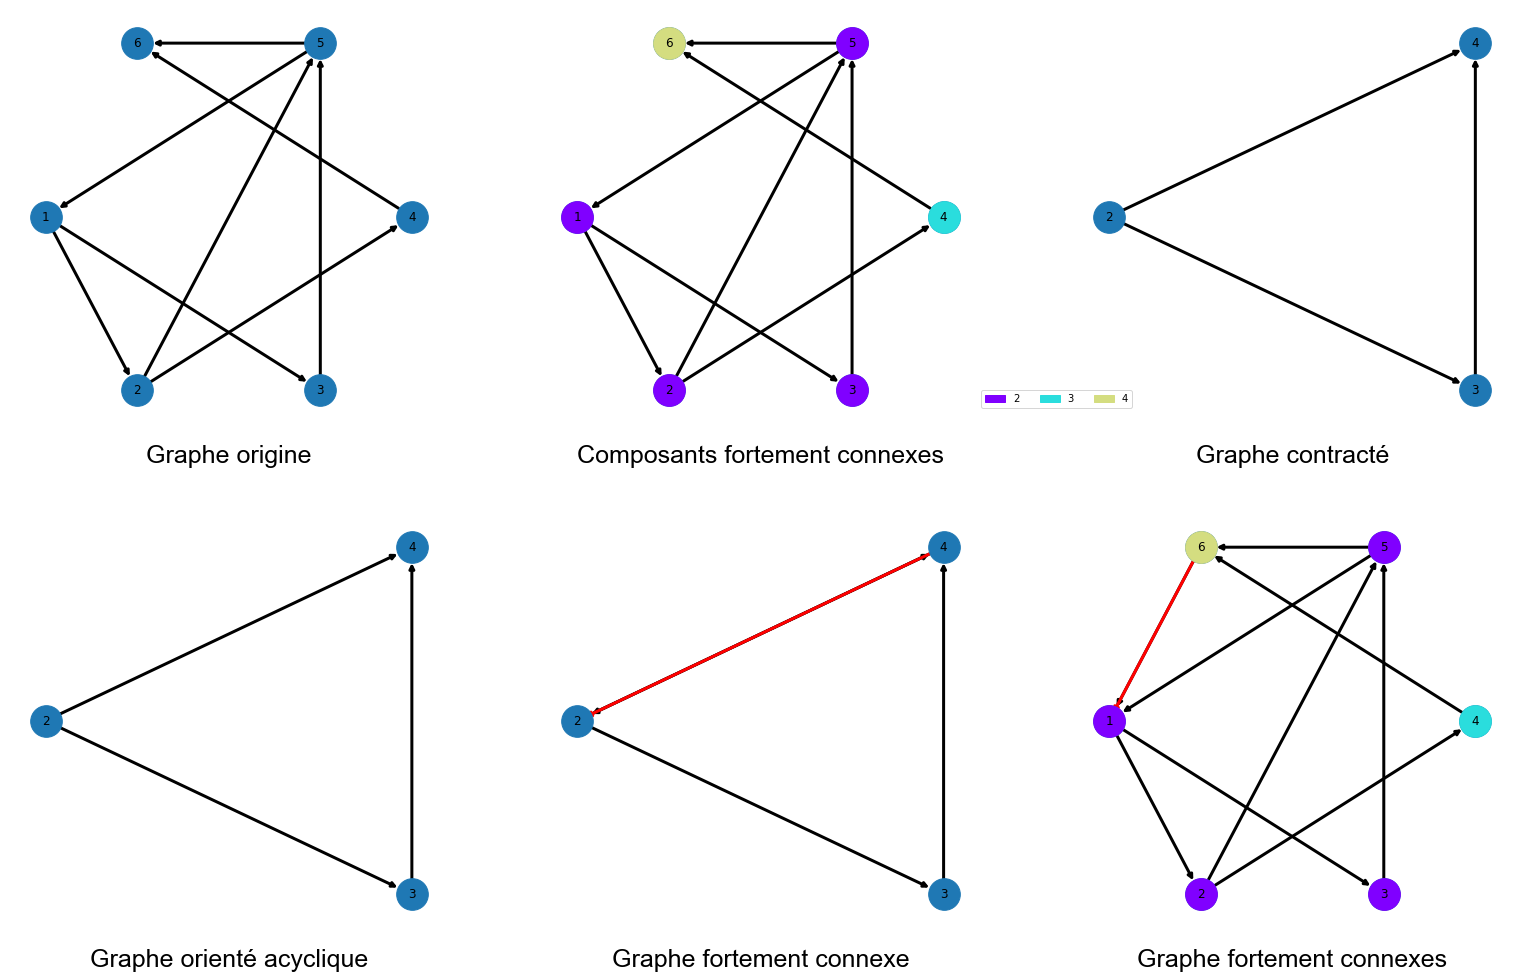

Les composants fortement connexes sont :
    2 : [1, 5, 3, 2]
    3 : [4]
    4 : [6]
Le nombre minimal d'arête à ajouter est : 1
Un choix pour les arêtes à ajouter est : [(6, 1)]

------------------------------------------------------------------------------------------

Graphe 2 :


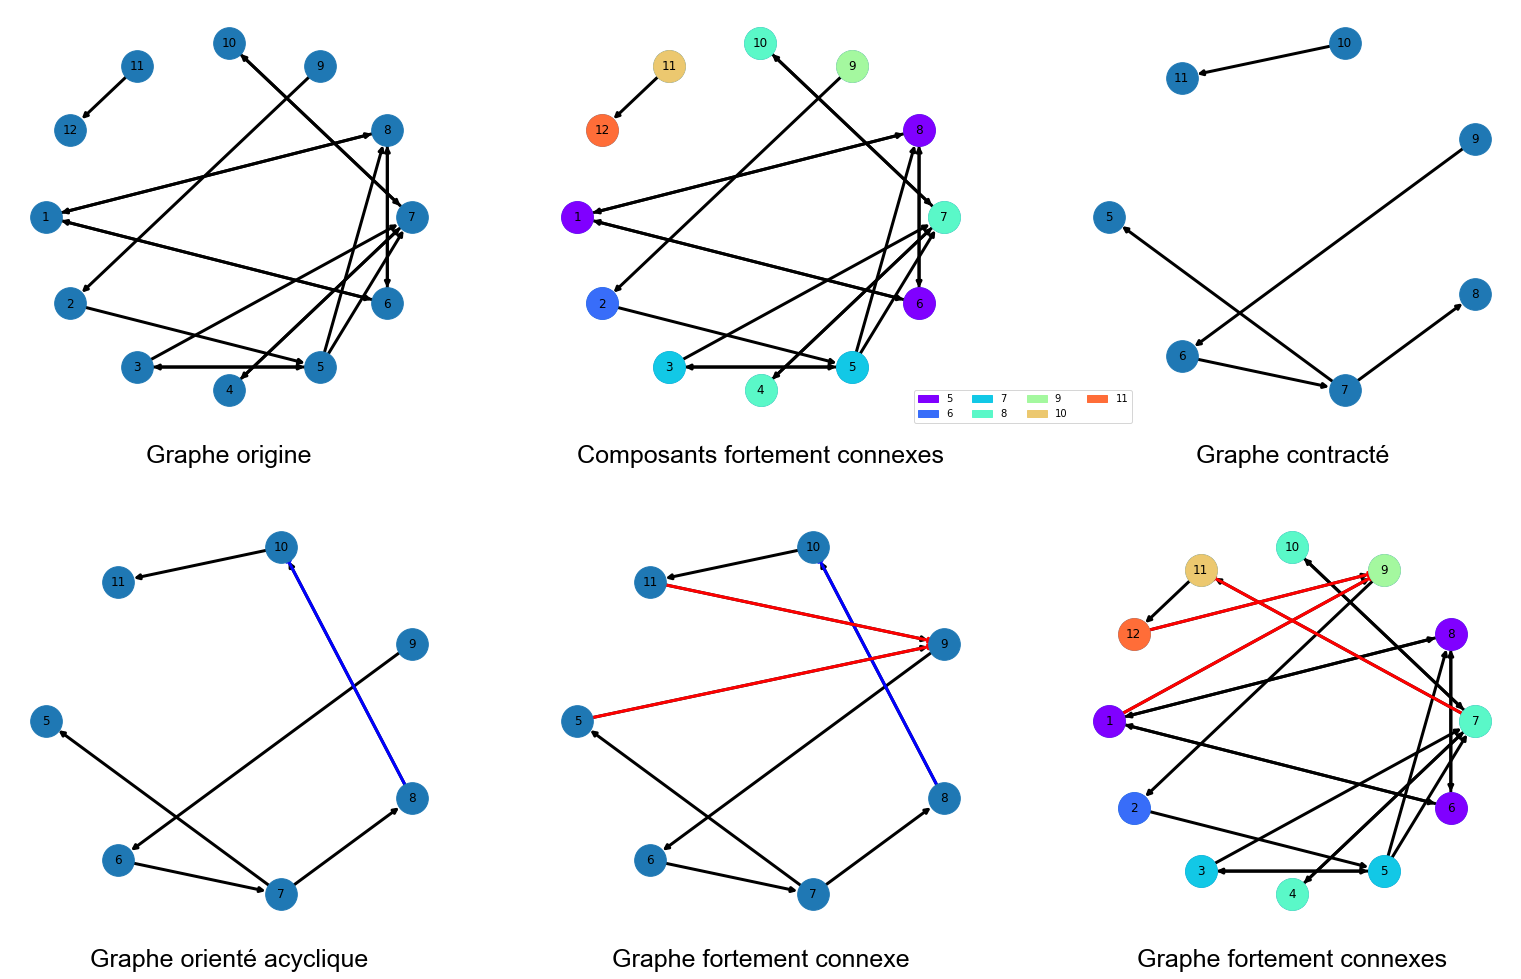

Les composants fortement connexes sont :
    5 : [1, 8, 6]
    6 : [2]
    7 : [5, 3]
    8 : [7, 10, 4]
    9 : [9]
    10 : [11]
    11 : [12]
Le nombre minimal d'arête à ajouter est : 3
Un choix pour les arêtes à ajouter est : [(7, 11), (12, 9), (1, 9)]

------------------------------------------------------------------------------------------

Graphe 3 :


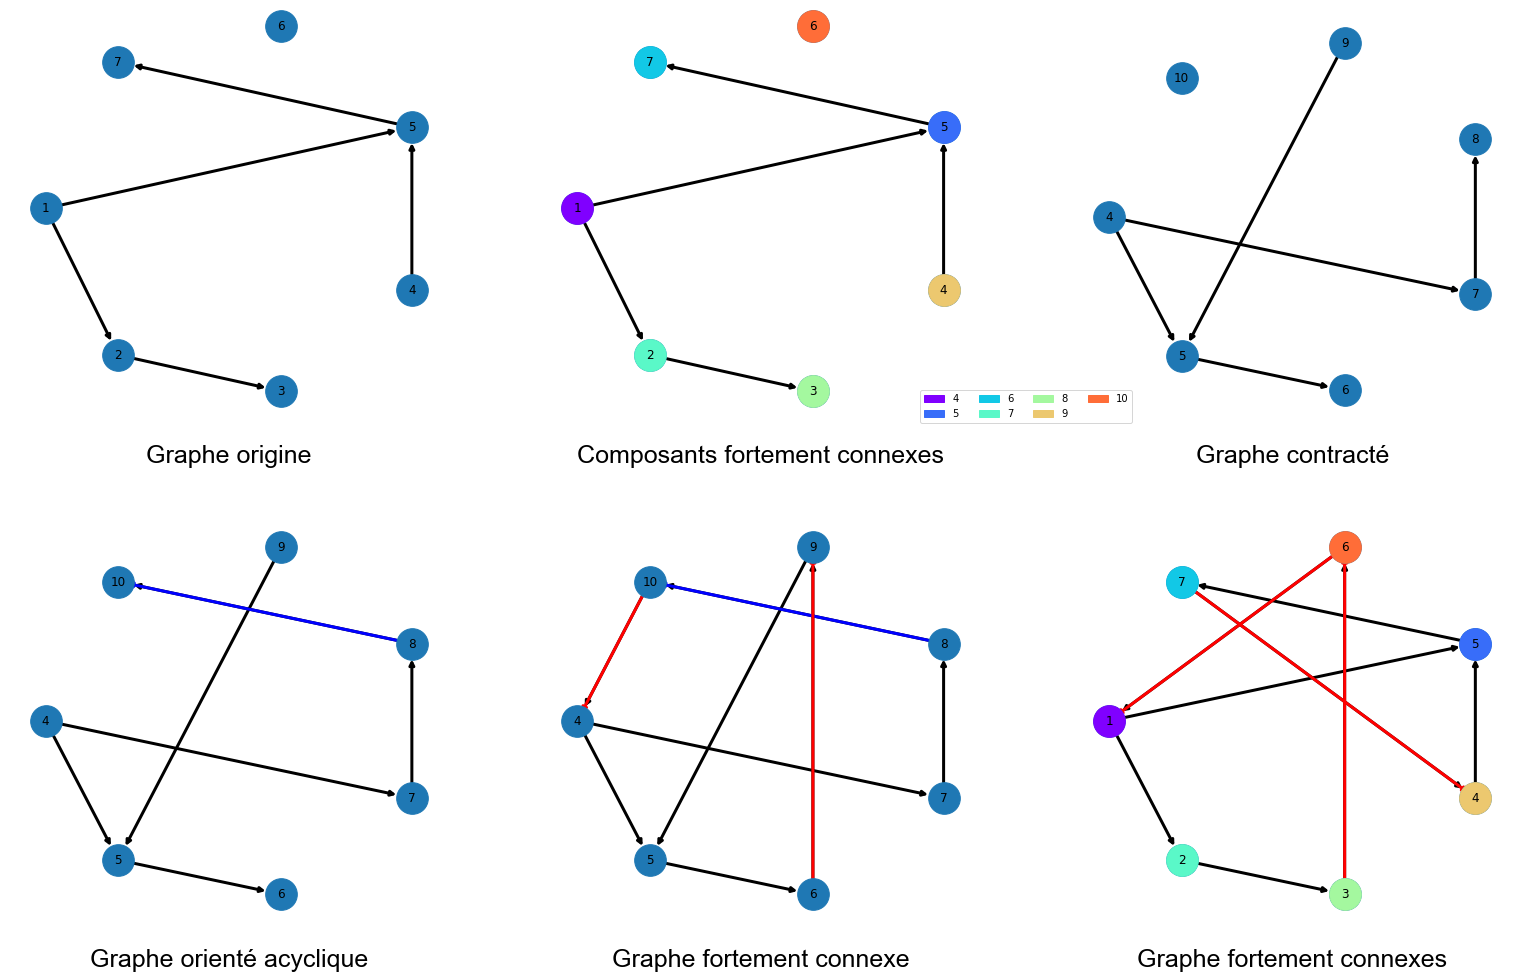

Les composants fortement connexes sont :
    4 : [1]
    5 : [5]
    6 : [7]
    7 : [2]
    8 : [3]
    9 : [4]
    10 : [6]
Le nombre minimal d'arête à ajouter est : 3
Un choix pour les arêtes à ajouter est : [(3, 6), (6, 1), (7, 4)]

------------------------------------------------------------------------------------------

Graphe 4 :


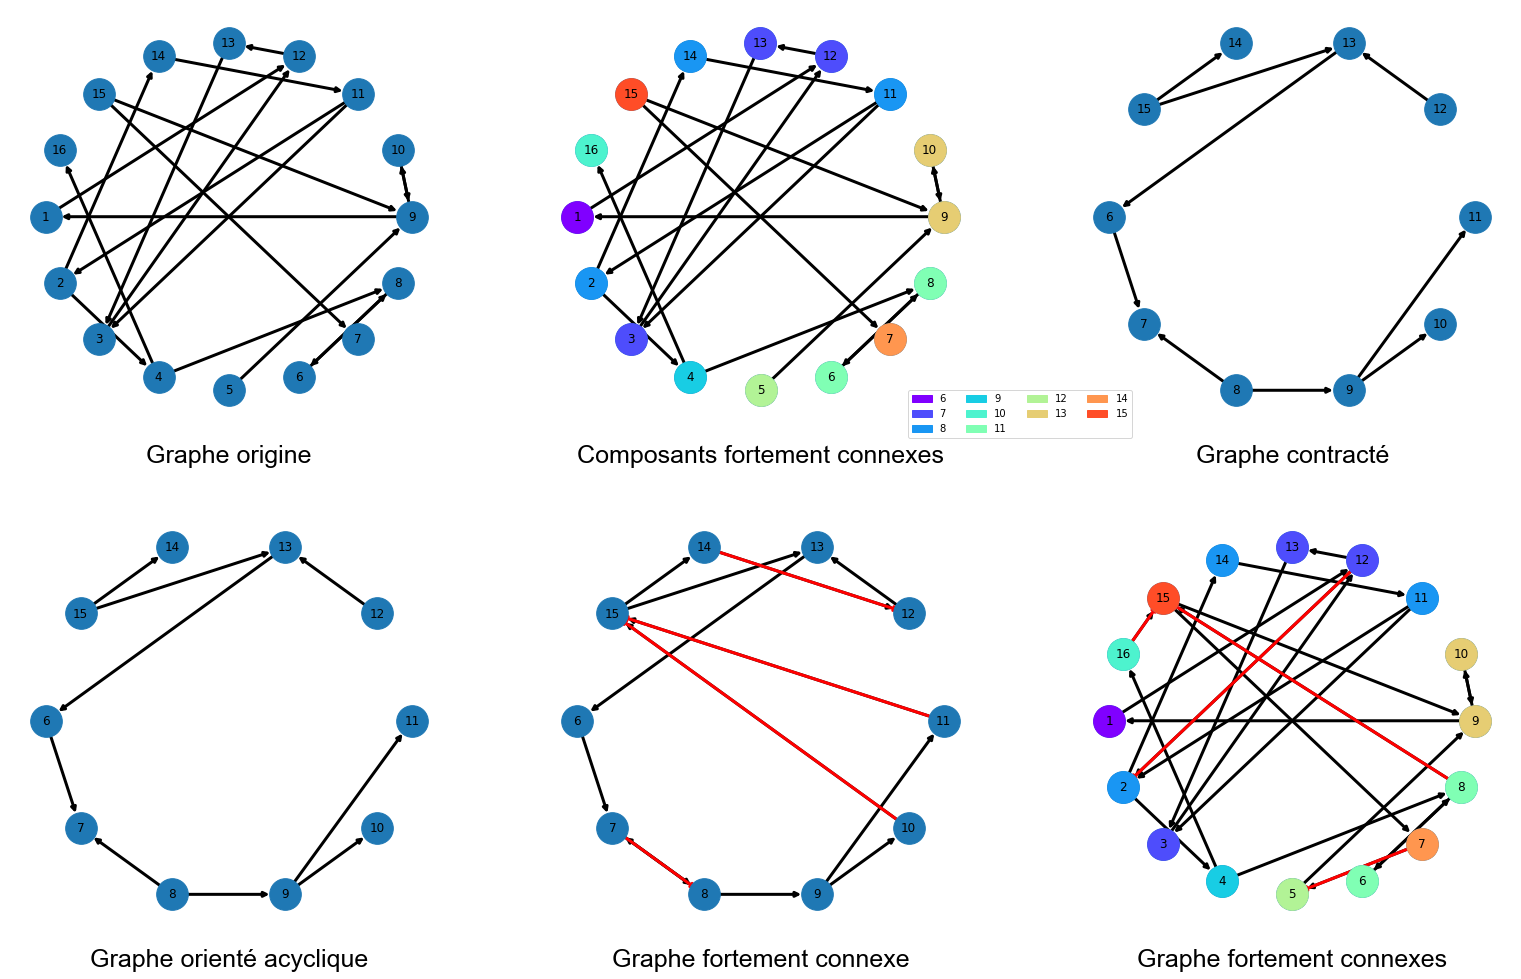

Les composants fortement connexes sont :
    6 : [1]
    7 : [12, 3, 13]
    8 : [2, 11, 14]
    9 : [4]
    10 : [16]
    11 : [8, 6]
    12 : [5]
    13 : [9, 10]
    14 : [7]
    15 : [15]
Le nombre minimal d'arête à ajouter est : 4
Un choix pour les arêtes à ajouter est : [(8, 15), (7, 5), (12, 2), (16, 15)]



In [6]:
test = TestGraph()
for i, G in enumerate(test):
    print("------------------------------------------------------------------------------------------")
    print("")
    print("Graphe", i+1, ":")
    test.demo(G)
    print("")